In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# import the necessary packages
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn 
import random
import pickle
import time
import cv2
import os
os.chdir("/content/drive/MyDrive/offline/projects/ml/biometricECG/")
!ls

Mounted at /content/drive
apidata.py	 image_siamese.ipynb   mit.ipynb      siamese.py
cnn.py		 images.py	       models	      signal.ipynb
data		 LICENSE	       __pycache__    signals.py
dummy.py	 logs		       README.md      signal_vgg.ipynb
enroll.ipynb	 media		       run.py	      train.ipynb
environment.yml  mit_1d_processing.py  setup.py       trials
features.py	 mit_3000.ipynb        siamese.ipynb  venv


In [ ]:
# load dataset
pickleIn = open('data/ready/pickles/cnn.pickle', 'rb')
people, y, x = pickle.load(pickleIn)

['100', '100', '100', '100', '100', '100', '100', '100', '100', '100']


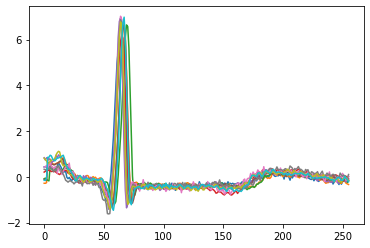

In [ ]:
why = []
for i in range(10):
  why.append(y[i])
  plt.plot(x[i])
print(why)
plt.show()

In [ ]:
# shuffle data
from collections import Counter

# print(Counter(y))
length = len(y)
print(length)
data = []
for i in range(length):
  data.append([y[i], x[i]])

print(y)
print(y[2])

plt.plot(x[2], linewidth=0.8, color="k")
plt.show()

num = random.randint(0, length)
random.seed(num)
random.shuffle(data)

y, x = [], []
for k in range(length):
  y.append(data[k][0])
  x.append(data[k][1])

data, k, length, num = [], 0, 0, 0 # just for memory management

print(y)
print(y[2])

plt.plot(x[2], linewidth=0.8, color="k")
plt.show()

In [ ]:
x = np.array(x)

print('Before Normalization\n')
print('Shape:', x.shape)
print('Min:', x.min(), 'Max:', x.max())
print(x.dtype)

print('\nAfter Normalization\n')

x = (x - x.min()) / (x.max() - x.min())
y = np.array(y)

print('Shape:', x.shape)
print('Min:', x.min(), 'Max:', x.max())
print(x.dtype)

Before Normalization

Shape: (397740, 256)
Min: -7.565526962280273 Max: 8.537934070241493
float64

After Normalization

Shape: (397740, 256)
Min: 0.0 Max: 1.0
float64


In [ ]:
from sklearn.preprocessing import LabelBinarizer

SIG_DIMS = (x.shape[1], 1)

# binarize the labels
lb = LabelBinarizer()
y = lb.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.4, shuffle=True, random_state=42)

x_valid, x_test, y_valid, y_test = train_test_split(
    x_test, y_test, test_size=0.3, shuffle=True, random_state=42)

x, y = [], []  # just for memory management

print(x_train.shape)
x_train = x_train.reshape(x_train.shape[0], SIG_DIMS[0], SIG_DIMS[1])
x_valid = x_valid.reshape(x_valid.shape[0], SIG_DIMS[0], SIG_DIMS[1])
x_test = x_test.reshape(x_test.shape[0], SIG_DIMS[0], SIG_DIMS[1])
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)

['100' '101' '102' '103' '104' '105' '106' '107' '108' '109' '111' '112'
 '113' '114' '115' '116' '117' '118' '119' '121' '122' '123' '124' '1975'
 '200' '201' '202' '203' '205' '207' '208' '209' '210' '212' '213' '214'
 '215' '217' '219' '220']
(238644, 256)
(238644, 256, 1)
(111367, 256, 1)
(47729, 256, 1)


In [ ]:
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, concatenate, Conv1D, MaxPool1D, Activation, Flatten, Dropout, Dense, Input, Add
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import Adam
from google.colab.patches import cv2_imshow
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
%load_ext tensorboard
from tensorflow.keras import layers
%matplotlib inline
import numpy as np
import random
import pickle
import time
import cv2
import os
import gc

In [ ]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 100
BS = 64
SIG_DIMS = (x_train.shape[1], 1)
LR = 0.00001
decay = LR/EPOCHS
adam = Adam(learning_rate=LR,decay=decay)

def block(model, fs, ks, ps):
  model.add(Conv1D(filters=fs, kernel_size=ks, padding="same"))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool1D(pool_size=ps, padding='same'))
  return model

def SPPLayer(inp, spp_windows):
  p_poolings = []

  for pi in range(len(spp_windows)):
    p_poolings.append(Flatten()(MaxPool1D(pool_size=spp_windows[pi], padding='same')(inp)))
  out = concatenate(p_poolings, axis=-1)

  return out


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 256, 128)          256       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 128)          512       
_________________________________________________________________
activation (Activation)      (None, 256, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 256, 256)          491776    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256)          1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 128, 256)          0

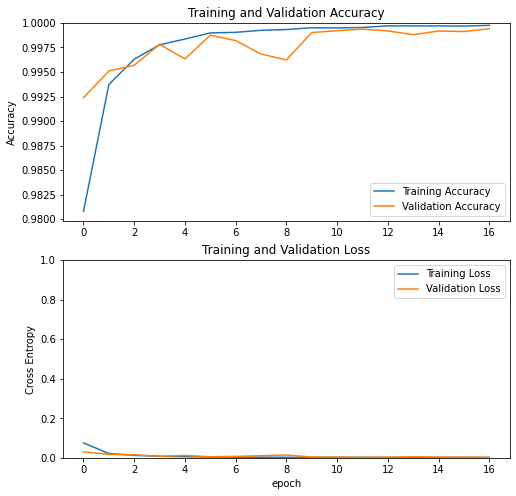

In [ ]:
folder = "models/cnn/"
if not os.path.exists(folder):
  os.makedirs(folder)

# save the label binarizer to disk
f = open(folder + "lb.pickle", "wb")
f.write(pickle.dumps(lb))
f.close()

# Model
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=1, padding="same", input_shape=SIG_DIMS))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Blocks
model = block(model, 32 * 2, 15, 2)
model = block(model, 32 * 4, 15, 2)
model = block(model, 32 * 8, 15, 2)
model = block(model, 32 * 16, 15, 2)
last = 1 + 2 + 4 + 8 + 16
model = block(model, 32 * last, 15, 2)

# Fully Connected Layer
model.add(Flatten())
model.add(Dense(32 * last))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# softmax classifier
model.add(Dense(len(lb.classes_)))
model.add(Activation("softmax"))

print(model.summary())

model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])

STEPS_PER_EPOCH = len(x_train) // BS
VAL_STEPS_PER_EPOCH = len(x_valid) // BS

bestmodel = folder + "debbis"
checkpointer = ModelCheckpoint(filepath=bestmodel, verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Define the Keras TensorBoard callback.
logdir = folder + "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

# fit network
t = time.time()

H = model.fit(x_train, y_train, batch_size=BS,
              validation_data=(x_valid, y_valid),
              steps_per_epoch=STEPS_PER_EPOCH,
              validation_steps=VAL_STEPS_PER_EPOCH,
              epochs=EPOCHS, verbose=1, 
              callbacks=[tensorboard_callback, checkpointer, early_stopping])

print('\nTraining time: ', time.time() - t)

# save the model to disk
model.save(bestmodel)

# evaluate model
_, accuracy = model.evaluate(x_test, y_test, batch_size=BS, verbose=1)
print('\n', 'Test accuracy:', accuracy, '\n')

# plot the training loss and accuracy
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']

loss = H.history['loss']
val_loss = H.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
%tensorboard --logdir models/auth/8/logs/fit

In [ ]:
_, accuracy = model.evaluate(x_test, y_test)
print('\n', 'Test accuracy:', accuracy, '\n')

375/375 [==============================] - 4s 9ms/step - loss: 0.0058 - accuracy: 0.9987

 Test accuracy: 0.9986666440963745 



In [ ]:
from sklearn.metrics import classification_report

lbb = LabelBinarizer()
predictions = model.predict(x_test, batch_size=BS, verbose=1)
y_pred_bool = np.argmax(predictions, axis=1)
y_pred_bool = lbb.fit_transform(y_pred_bool)
print(classification_report(y_test, y_pred_bool))

188/188 [==============================] - 2s 11ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       303
           1       1.00      1.00      1.00       314
           2       1.00      1.00      1.00       299
           3       1.00      1.00      1.00       328
           4       1.00      1.00      1.00       305
           5       1.00      1.00      1.00       313
           6       1.00      1.00      1.00       318
           7       1.00      1.00      1.00       324
           8       1.00      1.00      1.00       290
           9       1.00      1.00      1.00       303
          10       1.00      1.00      1.00       319
          11       1.00      1.00      1.00       301
          12       1.00      1.00      1.00       297
          13       1.00      1.00      1.00       317
          14       1.00      1.00      1.00       289
          15       0.99      1.00      1.00       281
          16       1.00  

In [ ]:
predictions = model.predict(x_test)
print(len(predictions))

up, down = [], []
for i in predictions:
  pred = max(i)
  if pred >= 0.99:
    up.append(pred)
  else:
    down.append(pred)
  
print("Up:", len(up))
print(up, "\n")
print("Down:", len(down))
print(down, "\n")

fig = plt.figure(figsize=(64, 54))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=225, replace=False)):
    pred_idx = np.argmax(predictions[idx])
    true_idx = np.argmax(y_test[idx])
    probs = predictions[pred_idx]
    prob = max(predictions[pred_idx])
    ax = fig.add_subplot(15, 15, i + 1, xticks=[], yticks=[])
    ax.plot(x_test[idx])
    ax.set_title("T: {} P: {} {:.6f}".format(lb.classes_[true_idx], lb.classes_[pred_idx], prob),
                 color=("green" if pred_idx == true_idx else "red"))
    # ax.set_xlabel(probs)

Confusion matrix, without normalization
[[1172    0    0 ...    0    0    0]
 [   0 1169    0 ...    0    0    0]
 [   0    0 1261 ...    0    0    0]
 ...
 [   0    0    0 ... 1279    0    0]
 [   0    0    0 ...    0 1168    0]
 [   0    0    0 ...    0    0 1158]]


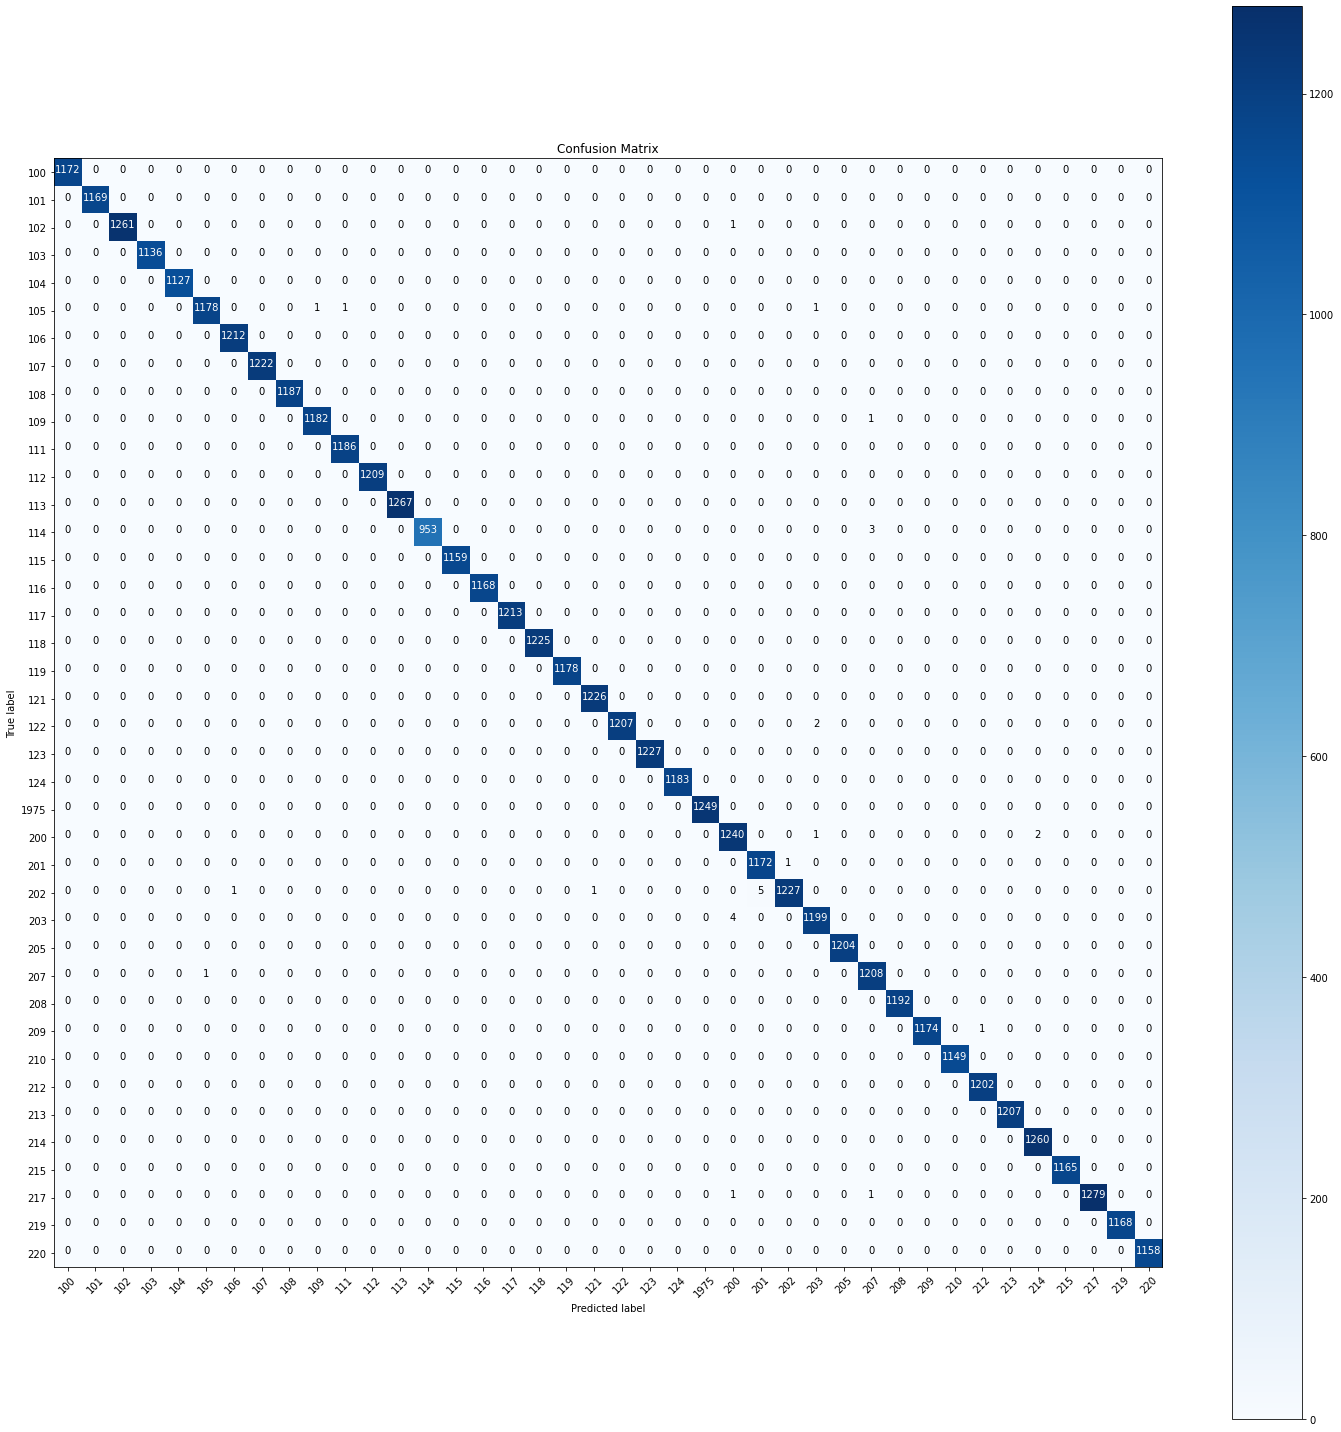

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

test = np.argmax(y_test, axis=1)
preds = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_true=test, y_pred=preds)
plot_confusion_matrix(cm=cm, classes=lb.classes_, title='Confusion Matrix')